In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [16]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(itos)

In [17]:
# build dataset
block_size = 3 # context length: how many chars take to predict next
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[n2:]) #10%

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [20]:
n_emb = 10 # dim of char vector embeddings
n_hidden = 200 # number of hidden layers 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g, requires_grad = True) #rand unfirm dist. (0,1) vs. randn gaussian dist mean 0
W1 = torch.randn((n_emb * block_size,n_hidden), generator=g, requires_grad = True)
b1 = torch.randn(n_hidden, generator=g, requires_grad = True)
W2 = torch.randn((n_hidden,vocab_size), generator=g, requires_grad = True)
b2 = torch.randn(vocab_size, generator=g, requires_grad = True)
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)

11897

In [24]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # forward pass
    # minibatch (approx. gradient)
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # batch_size random row index'
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb] #emb chars to vector
    h = torch.tanh(emb.view(-1, n_emb * block_size) @ W1 + b1) # hidden layer , -1 torch infers size
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # update
    for p in params:
        lr = 0.1 if i < 100000 else 0.01 # can be found w graph of loss against lr, step learning rate decay
        p.data += -lr * p.grad # how determine learning rate?

    if i%10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 18.5303
  10000/ 200000: 2.8931
  20000/ 200000: 2.3452
  30000/ 200000: 2.2845
  40000/ 200000: 1.6704
  50000/ 200000: 2.1648
  60000/ 200000: 2.1775
  70000/ 200000: 1.9223
  80000/ 200000: 2.8820
  90000/ 200000: 2.0490
 100000/ 200000: 1.9916
 110000/ 200000: 2.2259
 120000/ 200000: 2.0184
 130000/ 200000: 2.2716
 140000/ 200000: 1.9827
 150000/ 200000: 2.0006
 160000/ 200000: 1.9395
 170000/ 200000: 1.6762
 180000/ 200000: 1.7462
 190000/ 200000: 1.5633


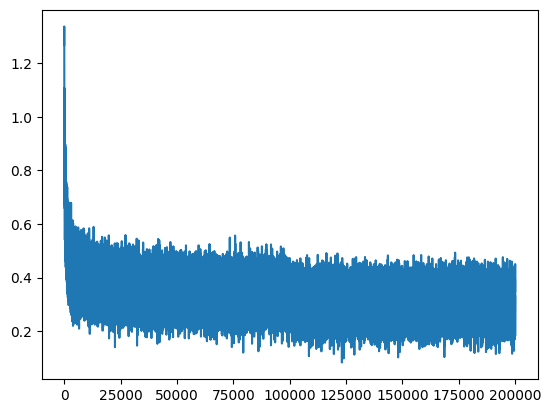

In [25]:
plt.plot(lossi)

In [29]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06591796875
val 2.400566816329956


In [30]:
# sampling
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(20):
    out = []
    context = [0] * block_size # .... init
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmaveah.
jhliah.
jori.
jehtyn.
kandencer.
hutefamirahcilaqui.
nellara.
chaiir.
kaleigh.
ham.
joce.
quint.
shonne.
livebi.
waverly.
jarynix.
kael.
dusti.
edde.
oia.
